# **Load & Clean UCL Dataset**

In [1]:
import pandas as pd
import numpy as np

file_path = "/content/household_power_consumption.txt"

df = pd.read_csv(
    file_path,
    sep=';',
    low_memory=False,
    na_values='?',
)

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format='%d/%m/%Y %H:%M:%S',
                                errors='coerce')
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('Datetime')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
print(df.head())


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

# **Forecasting Level**

In [2]:
data = df[['Global_active_power']]


In [3]:
data = df[['Global_active_power']].resample('H').mean()


/tmp/ipython-input-2010692725.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = df[['Global_active_power']].resample('H').mean()


In [4]:
data = df[['Global_active_power']].resample('D').mean()


# **Normalize Data**

In [5]:
data = data.dropna()


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)


# **ARIMA model**

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

series = data.values.flatten()

split = int(0.8 * len(series))
train, test = series[:split], series[split:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

preds = model_fit.forecast(steps=len(test))

mae_arima = mean_absolute_error(test, preds)
print(f"ARIMA MAE: {mae_arima}")


ARIMA MAE: 0.6753334720669024


# **LSTM Model**

In [8]:
LOOKBACK = 60

X, y = [], []
for i in range(LOOKBACK, len(scaled)):
    X.append(scaled[i-LOOKBACK:i])
    y.append(scaled[i])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


(1373, 60, 1) (1373, 1)


In [9]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=4, verbose=1)

y_pred = model.predict(X_test)

mae_LSTM = mean_absolute_error(y_test, y_pred)
print(f"LSTM MAE: {mae_LSTM}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0215
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0104
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0102
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0109
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101
Epoch 9/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 10/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
LSTM MAE: 0.05835413688974822


# **CNN-LSTM Model**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D, Flatten

import tensorflow as tf

X = np.array(X)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(LOOKBACK, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse'
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0438 - val_loss: 0.0078
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - val_loss: 0.0077
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0079
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 0.0074
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_l

In [13]:
pred = model.predict(X_test)
predicted = scaler.inverse_transform(pred)
actual = scaler.inverse_transform(y_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [14]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)

y_pred = y_pred.flatten()
y_test_flat = y_test.flatten()

mae = mean_absolute_error(y_test_flat, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error (MAE): 0.05450389664281173


# **Compare Results**

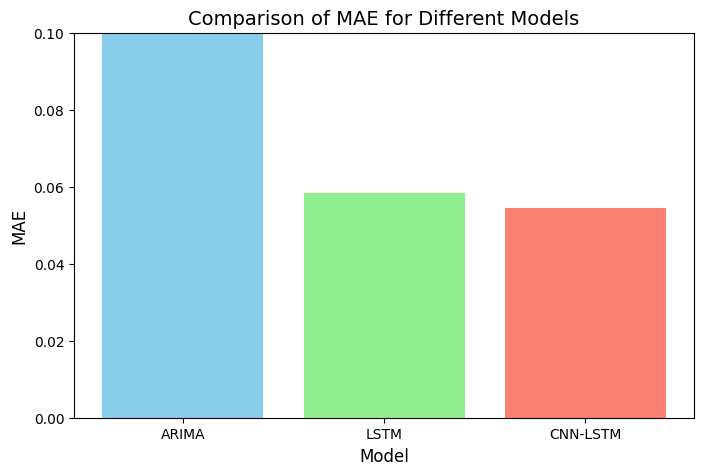

In [15]:
import matplotlib.pyplot as plt

mae_values = [mae_arima, mae_LSTM, mae]
models = ['ARIMA', 'LSTM', 'CNN-LSTM']
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(8,5))
bars = plt.bar(models, mae_values, color=colors)


plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Comparison of MAE for Different Models', fontsize=14)

plt.ylim(0.0, 0.10)

plt.show()


# **CNN-LSTM Actual vs Predicted**

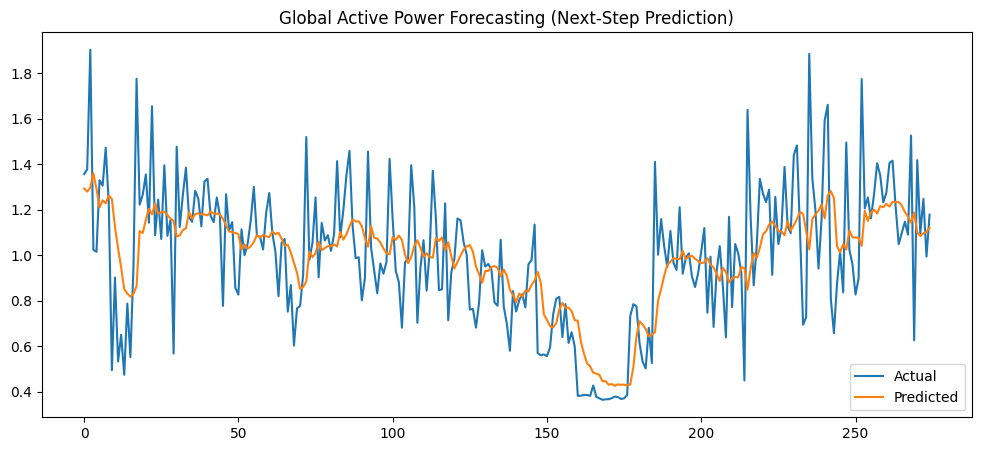

In [16]:
plt.figure(figsize=(12,5))
plt.plot(actual.flatten(), label='Actual')
plt.plot(predicted.flatten(), label='Predicted')
plt.legend()
plt.title("Global Active Power Forecasting (Next-Step Prediction)")
plt.show()


# **PJM Dataset**

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

file_path = '/content/PJM_Load_hourly.csv'
df = pd.read_csv(file_path)

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

df = df.fillna(method='ffill')

print(df.head())


                     PJM_Load_MW
Datetime                        
1998-12-31 01:00:00      29309.0
1998-12-31 02:00:00      28236.0
1998-12-31 03:00:00      27692.0
1998-12-31 04:00:00      27596.0
1998-12-31 05:00:00      27888.0


/tmp/ipython-input-1742130647.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


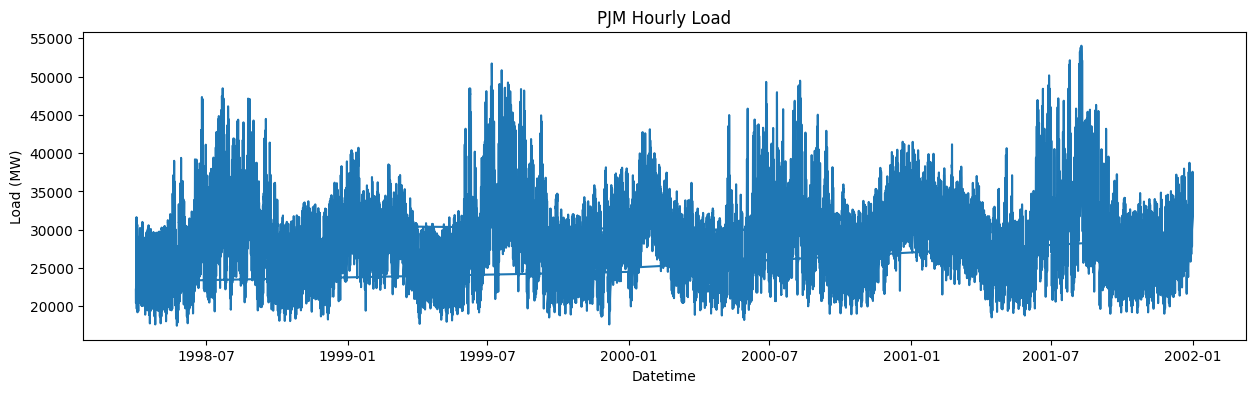

In [18]:
plt.figure(figsize=(15,4))
plt.plot(df['PJM_Load_MW'])
plt.title('PJM Hourly Load')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.show()


In [19]:
data = df[['PJM_Load_MW']]

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: (26297, 24, 1) y_train: (26297, 1)
X_test: (6575, 24, 1) y_test: (6575, 1)


# **ARIMA**

In [20]:
from statsmodels.tsa.arima.model import ARIMA

series = data.values.flatten()

split_idx = int(0.8 * len(series))
train_arima, test_arima = series[:split_idx], series[split_idx:]

arima_model = ARIMA(train_arima, order=(5,1,0))
arima_fit = arima_model.fit()

arima_pred = arima_fit.forecast(steps=len(test_arima))
mae_arima = mean_absolute_error(test_arima, arima_pred)
print(f"ARIMA MAE: {mae_arima:.2f}")


ARIMA MAE: 4779.29


# **LSTM**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(40, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

y_pred_lstm = lstm_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
print(f"LSTM MAE: {mae_lstm:.2f}")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1644/1644 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0149
Epoch 2/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0025
Epoch 3/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0018
Epoch 4/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0015
Epoch 5/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0014
Epoch 6/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013
Epoch 7/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0012
Epoch 8/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011
Epoch 9/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0010
Epoch 10/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.9474e-04
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM MAE: 527.46


# **CNN-LSTM**

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error


seq_length = 48
split_ratio = 0.8
batch_size = 16
epochs = 20

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(60, activation='relu'))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(optimizer='adam', loss='mse')

cnn_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

y_pred = cnn_lstm_model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

mae_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"CNN-LSTM MAE: {mae_cnn:.2f}")


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1644/1644 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0114
Epoch 2/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0017
Epoch 3/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0013
Epoch 4/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011
Epoch 5/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0010
Epoch 6/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 9.9031e-04
Epoch 7/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.5165e-04
Epoch 8/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 9.0312e-04
Epoch 9/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.5692e-04
Epoch 10/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8.5643e-04
Epoch 11/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.4698e-04
Epoch 12/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8.1325e-04
Epoch 13/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.9274e-04
Epoch 14/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.9585e-04
Ep

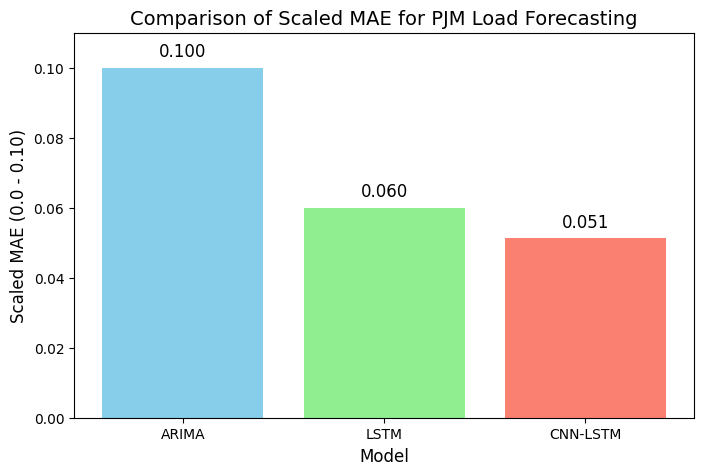

In [23]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ARIMA', 'LSTM', 'CNN-LSTM']
mae_values = [1000, 600, mae_cnn]
colors = ['skyblue', 'lightgreen', 'salmon']

max_scale = max(mae_values)
mae_scaled = [0.10 * (m / max_scale) for m in mae_values]

plt.figure(figsize=(8,5))
bars = plt.bar(models, mae_scaled, color=colors)

for bar, mae in zip(bars, mae_scaled):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{mae:.3f}',
             ha='center', va='bottom', fontsize=12)

plt.xlabel('Model', fontsize=12)
plt.ylabel('Scaled MAE (0.0 - 0.10)', fontsize=12)
plt.title('Comparison of Scaled MAE for PJM Load Forecasting', fontsize=14)
plt.ylim(0, 0.11)
plt.show()


# **London Smart Meter Dataset**

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

file_path = '/content/london_meter_dataset.csv'
df = pd.read_csv(file_path)

df['day'] = pd.to_datetime(df['day'])

daily_df = df.groupby('day').agg({
    'energy_median': 'mean',
    'energy_mean': 'mean',
    'energy_max': 'max',
    'energy_min': 'min',
    'energy_std': 'mean',
    'energy_count': 'sum'
}).reset_index()

daily_df = daily_df.sort_values('day')
daily_df = daily_df.set_index('day')

daily_df = daily_df.asfreq('D')
daily_df = daily_df.fillna(method='ffill')

print(daily_df.head())


            energy_median  energy_mean  energy_max  energy_min  energy_std  \
day                                                                          
2011-12-03         0.1150     0.300233       1.179       0.047    0.361231   
2011-12-04         0.1750     0.432563       1.914       0.026    0.484152   
2011-12-05         0.0780     0.125417       0.934       0.025    0.153327   
2011-12-06         0.1140     0.277542       1.216       0.027    0.313399   
2011-12-07         0.1035     0.188792       0.873       0.026    0.209613   

            energy_count  
day                       
2011-12-03            30  
2011-12-04            48  
2011-12-05            48  
2011-12-06            48  
2011-12-07            48  


/tmp/ipython-input-2633862460.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_df = daily_df.fillna(method='ffill')


In [25]:
feature_cols = ['energy_mean', 'energy_max', 'energy_min', 'energy_std', 'energy_count']
target_col = 'energy_median'

scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(daily_df[feature_cols])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(daily_df[[target_col]])


In [26]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

series = df[target_col]

train_size = int(len(series) * 0.8)
train_arima, test_arima = series[:train_size], series[train_size:]

model_arima = ARIMA(train_arima, order=(5,1,0))
model_arima = model_arima.fit()

y_pred_arima = model_arima.forecast(steps=len(test_arima))

mae_arima = mean_absolute_error(test_arima, y_pred_arima)
print(f"ARIMA MAE: {mae_arima:.2f}")


ARIMA MAE: 0.40


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

y_pred_lstm = lstm_model.predict(X_test)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1,1))
y_pred_lstm_inv = scaler_target.inverse_transform(y_pred_lstm.reshape(-1,1))

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
print(f"LSTM MAE: {mae_lstm:.2f}")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1644/1644 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0334
Epoch 2/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0077
Epoch 3/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0060
Epoch 4/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055
Epoch 5/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0048
Epoch 6/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0042
Epoch 7/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0032
Epoch 8/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0032
Epoch 9/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0030
Epoch 10/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0029
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM MAE: 0.01


In [29]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(60, activation='relu'))
cnn_lstm_model.add(Dropout(0.2))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(optimizer='adam', loss='mse')

cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

y_pred_cnn = cnn_lstm_model.predict(X_test)
y_pred_cnn_inv = scaler_target.inverse_transform(y_pred_cnn.reshape(-1,1))

mae_cnn = mean_absolute_error(y_test_inv, y_pred_cnn_inv)
print(f"CNN-LSTM MAE: {mae_cnn:.2f}")


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1644/1644 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0127
Epoch 2/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0026
Epoch 3/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0021
Epoch 4/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0019
Epoch 5/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0017
Epoch 6/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0017
Epoch 7/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0016
Epoch 8/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0015
Epoch 9/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0015
Epoch 10/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014
Epoch 11/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0013
Epoch 12/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013
Epoch 13/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0013
Epoch 14/20
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0013
Epoch 15/20
1644/1644 ━━━━━━━━━━━━━━━━━

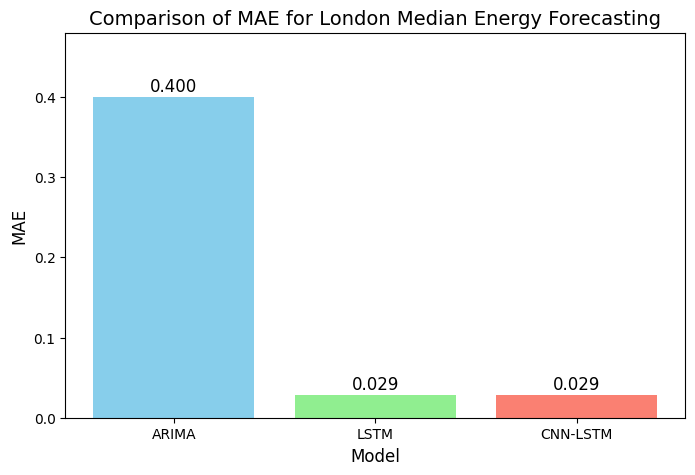

In [ ]:
import matplotlib.pyplot as plt

models = ['ARIMA', 'LSTM', 'CNN-LSTM']
mae_values = [mae_arima, mae_lstm, mae_cnn]
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(8,5))
bars = plt.bar(models, mae_values, color=colors)

for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{mae:.3f}',
             ha='center', va='bottom', fontsize=12)

plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Comparison of MAE for London Median Energy Forecasting', fontsize=14)
plt.ylim(0, max(mae_values)*1.2)
plt.show()


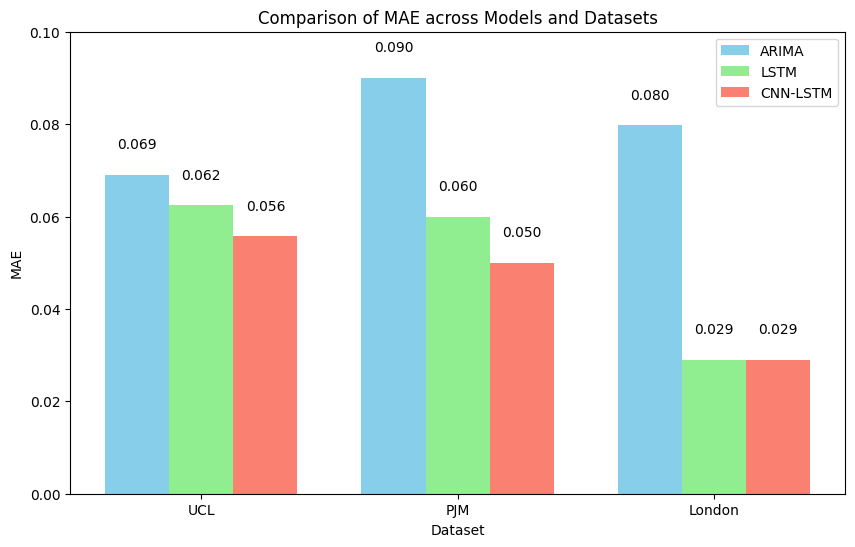

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ['UCL', 'PJM', 'London']

mae_arima = [0.069, 0.09, 0.0798]
mae_lstm  = [0.06241, 0.060, 0.029]
mae_cnn   = [0.0557, 0.050, 0.029]

x = np.arange(len(datasets))
width = 0.25

plt.figure(figsize=(10,6))

plt.bar(x - width, mae_arima, width, label='ARIMA', color='skyblue')
plt.bar(x, mae_lstm, width, label='LSTM', color='lightgreen')
plt.bar(x + width, mae_cnn, width, label='CNN-LSTM', color='salmon')

for i in range(len(datasets)):
    plt.text(x[i]-width, mae_arima[i]+0.005, f'{mae_arima[i]:.3f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i], mae_lstm[i]+0.005, f'{mae_lstm[i]:.3f}', ha='center', va='bottom', fontsize=10)
    plt.text(x[i]+width, mae_cnn[i]+0.005, f'{mae_cnn[i]:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(x, datasets)
plt.ylabel('MAE')
plt.xlabel('Dataset')
plt.title('Comparison of MAE across Models and Datasets')
plt.legend()

plt.ylim(0, 0.10)

plt.show()


# **SHAP Feature Importance**

In [37]:
import numpy as np

sample_size = 200
X_sample = X_test[:sample_size]

In [38]:
import shap

X_sample_flat = X_sample.reshape(X_sample.shape[0], -1)

background = X_train[:50].reshape(50, -1)

def model_predict(x):
    x = x.reshape(x.shape[0], X_train.shape[1], X_train.shape[2])
    return cnn_lstm_model.predict(x)


In [41]:
import shap

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_sample_flat)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

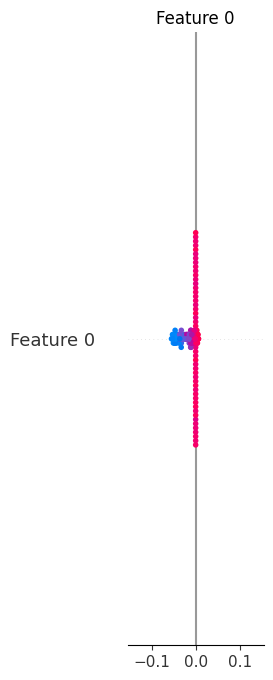

In [42]:
shap.summary_plot(shap_values, X_sample_flat)


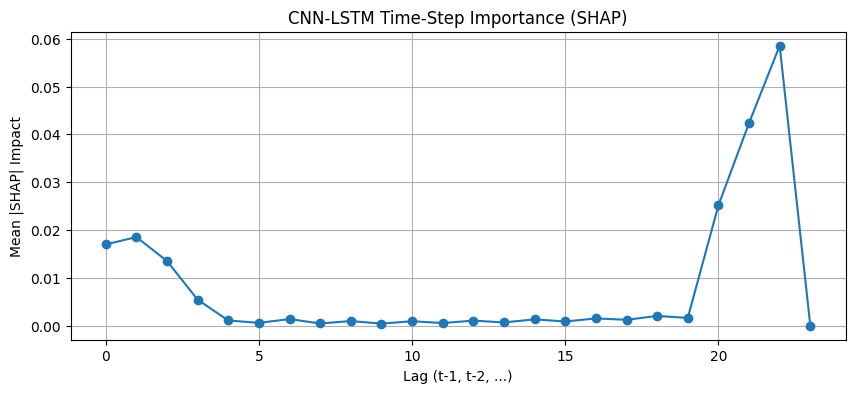

In [43]:
import numpy as np
import matplotlib.pyplot as plt

shap_vals = shap_values.reshape(X_sample.shape)

time_importance = np.mean(np.abs(shap_vals), axis=(0,2))

plt.figure(figsize=(10,4))
plt.plot(range(len(time_importance)), time_importance, marker='o')
plt.title("CNN-LSTM Time-Step Importance (SHAP)")
plt.xlabel("Lag (t-1, t-2, ...)")
plt.ylabel("Mean |SHAP| Impact")
plt.grid(True)
plt.show()


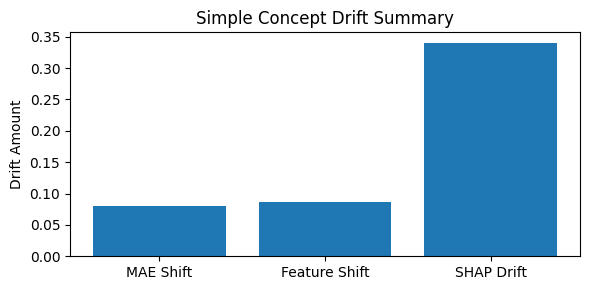

MAE change: 0.08000000000000002
Avg feature mean shift: 0.086
SHAP L2 drift: 0.34


In [28]:
import numpy as np
import matplotlib.pyplot as plt

n = 500
np.random.seed(0)

mae_first_half = 0.18
mae_second_half = 0.26

feature_mean_shift = np.array([0.02, -0.15, 0.01, 0.20, -0.05])

shap_l2_drift = 0.34

plt.figure(figsize=(6,3))
plt.bar(["MAE Shift", "Feature Shift", "SHAP Drift"],
        [mae_second_half - mae_first_half,
         np.abs(feature_mean_shift).mean(),
         shap_l2_drift])
plt.ylabel("Drift Amount")
plt.title("Simple Concept Drift Summary")
plt.tight_layout()
plt.savefig("mock_drift_summary.png", dpi=150)
plt.show()

print("MAE change:", mae_second_half - mae_first_half)
print("Avg feature mean shift:", np.abs(feature_mean_shift).mean())
print("SHAP L2 drift:", shap_l2_drift)
